In [2]:
from utils import prepare_pauli_operator
from tqdm import tqdm
from math import sqrt
import networkx as nx
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator
from graphstates import *
from weightedgraphstates import two_weighted_graph_states_ensemble,ensemble_with_sqrtcz, n_weighted_graph_states_ensemble
import numpy as np
import itertools 
from utils import prepare_intertwined_grid_with_endpoints, prepare_intertwined_twist_with_endpoints
def prod(gen,init=1):
    return reduce(operator.mul, gen, init)
from tqdm import *
import pickle
import matplotlib.pyplot as plt
from qutip.metrics import fidelity

In [8]:
#basically: for a given length and epsilon, determine the following:
# - reduced post-measurement state of the terminal qubits for (eps) edge loss probability,
# - reduced post-measurement state of the terminal qubits for zero noise,
# - numerically determine the fidelity of the first with respect to the second,
# - numerically determine the fidelity susceptibility, (1-fidelity)/epsilon.
# Here, only one measurement outcome is relevant (and postselected for):
#     all non-terminal qubits are measured in X basis with (-1) outcome.
def path_graph_check(length,eps,outcomes='-'):
    G=nx.path_graph(length+2)
    N=G.order()
    edges=G.edges
    cons={}
    terminal=[0,N-1]
    tomeasure=range(1,N-1)
    gse=n_weighted_graph_states_ensemble(N,edges,eps,10)
    signs=[0 for v in range(N)]
    for v in tomeasure:
        gse.measure_pauli_operator(v,'x',outcomes)
    consistent=True #taken from old code, where consistency checks were necessary. here it's automatic.
    if consistent:
        st1=gse.get_reduced_state(terminal,normalized=True)
        st2=gse.states[-1]['state'].get_reduced_state(terminal,normalized=True)
        con=fidelity(st1,st2)
    else:
        con=0
    sus=(1-con)/eps
    return sus
def crazy_graph_check(length,eps,outcomes='-'):
    G=prepare_intertwined_twist_with_endpoints(length)
    #nx.draw(G,with_labels=True)
    N=G.order()
    edges=G.edges
    cons={}
    postselcons={}
    terminal=[0,1]
    tomeasure=np.arange(2,N)
    gse=n_weighted_graph_states_ensemble(N,edges,eps,10)
    signs=[0 for v in range(N)]
    for v in tomeasure:
        gse.measure_pauli_operator(v,'x',outcomes)
    consistent=True
    if consistent:
        st1=gse.get_reduced_state(terminal,normalized=True)
        st2=gse.states[-1]['state'].get_reduced_state(terminal,normalized=True)
        con=fidelity(st1,st2)
    else:
        con=0
    sus=(1-con)/eps
    return sus
def twist_graph_check(length,eps,outcomes='-'):
    assert (length%2)==1
    G=prepare_intertwined_twist_with_endpoints(length)
    for i in range(4,2*length,4):#range(2,length-1,1):
        G=nx.contracted_nodes(G,i,i+1,self_loops=False)
    G=nx.convert_node_labels_to_integers(G)
    N=G.order()
    edges=G.edges
    terminal=[0,1]
    tomeasure=list(range(2,G.order()))
    gse=n_weighted_graph_states_ensemble(N,edges,eps,10)
    signs=[0 for v in range(N)]
    for v in tomeasure:
        gse.measure_pauli_operator(v,'x',outcomes)
    consistent=True
    if consistent:
        st1=gse.get_reduced_state(terminal,normalized=True)
        st2=gse.states[-1]['state'].get_reduced_state(terminal,normalized=True)
        con=fidelity(st1,st2)
    else:
        con=0
    sus=(1-con)/eps
    return sus

In [ ]:
# calculate the datapoints. this is quite fast because there is only one valid measurement outcome.

In [9]:
xs=[]
ys=[]
for n in [1,2,3,4,5,6,7,8,9]:
    print(n)
    ys.append(crazy_graph_check(n,0.001))
    xs.append(n)


1
2
3
4
5
6
7
8
9


In [10]:
xxxs=[]
yyys=[]
for n in [1,3,5,7,9]:
    print(n)
    yyys.append(twist_graph_check(n,0.001))
    xxxs.append(n)

1
3
5
7
9


In [11]:
xxs=[]
yys=[]
for n in [1,2,3,4,5,6,7,8,9]:
    print(n)
    yys.append(path_graph_check(n,0.001))
    xxs.append(n)

1
2
3
4
5
6
7
8
9


In [15]:
# definition of plot elements 

import matplotlib.path as mpath

star = mpath.Path.unit_regular_polygon(8)
circle = mpath.Path.unit_circle()
nvertices=np.dot(star.vertices,np.array([[.92,.38],[-.38,.92]]))
# concatenate the circle with an internal cutout of the star
own8 =  mpath.Path(
    vertices=np.concatenate([nvertices, 0.8*nvertices[::-1, ...]]),
    codes=np.concatenate([star.codes, star.codes]))

star = mpath.Path.unit_regular_polygon(4)
nvertices=np.array([[1,1],[-1,1],[-1,-1],[1,-1],[1,1]])
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
own4 = mpath.Path(
    vertices=np.concatenate([nvertices, 0.8*nvertices[::-1, ...]]),
    codes=np.concatenate([star.codes, star.codes]))


circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
owncirc = mpath.Path(
    vertices=np.concatenate([circle.vertices, 0.1*circle.vertices]),
    codes=np.concatenate([circle.codes, circle.codes]))

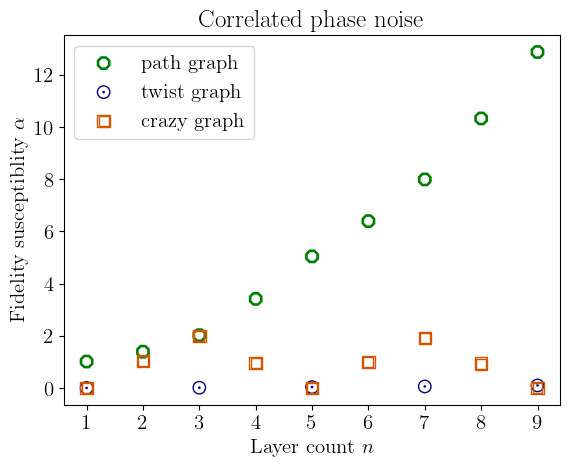

In [14]:
#plot itself.
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'],'size':15})
rc('text', usetex=True)
plt.legend(["crazy graph","twist graph","path graph"])
plt.rcParams['axes.facecolor'] = '#ffffff80'

plt.scatter(xxs,yys,marker=own8,facecolors="none",edgecolors="#008000",s=80)
plt.scatter(xxxs,yyys,marker=owncirc,facecolors="none",edgecolors="#000080",s=80)
plt.scatter(xs,ys,marker=own4,facecolors="none",edgecolors="#d45500",s=80)

plt.legend(["path graph","twist graph","crazy graph"])
plt.title("Correlated phase noise")
plt.xlabel("Layer count $n$")
plt.ylabel("Fidelity susceptiblity $\\alpha$")
plt.rcParams['axes.facecolor'] = '#ffffff80'
rc('font',**{'family':'serif','serif':['Palatino Linotype'],'size':12})
rc('text', usetex=True)